In [1]:
import json
import os
import math
import joblib
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Verifica a versão do TensorFlow
print(f"Bibliotecas importadas. TensorFlow version: {tf.__version__}")

2025-11-21 11:05:38.008986: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt

Bibliotecas importadas. TensorFlow version: 2.20.0


In [2]:
# Configurações de Visualização e Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
warnings.filterwarnings('ignore')

# Criação de diretórios de saída
OUTPUT_IMG_DIR = "imagens"
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)

# Caminhos Padrão
DATASET_PATH = 'lorawan_antwerp_2019_dataset.json'
GATEWAYS_PATH = 'lorawan_antwerp_gateway_locations.json'

# Carregamento de Configurações (config.json)
try:
    with open('config.json', 'r') as f:
        CONFIG = json.load(f)
    print("Configurações carregadas de 'config.json'.")
except FileNotFoundError:
    print("AVISO: 'config.json' não encontrado. Usando configurações padrão.")
    CONFIG = {}

# Configurações Específicas da Rede Neural (Fallback robusto)
NN_CONFIG = CONFIG.get('nn_config', {
    "gt_interval_seconds": 600, # 10 min
    "hidden_neurons": 10, 
    "epochs": 4000,
    "batch_size": 32, 
    "test_split_size": 0.2, 
    "validation_split_size": 0.1,
    "patience_early_stop": 50, 
    "default_rssi": -120.0,
    "model_save_path": "modelo_nn_lora_gt.h5",
    "input_scaler_save_path": "input_scaler.joblib",
    "output_scaler_save_path": "output_scaler.joblib"
})

print("Configurações de treinamento definidas.")

Configurações carregadas de 'config.json'.
Configurações de treinamento definidas.


In [3]:
def haversine(lat1, lon1, lat2, lon2):
    """Calcula a distância em metros entre duas coordenadas (Fórmula de Haversine)."""
    R = 6371000  # Raio da Terra em metros
    if any(v is None for v in [lat1, lon1, lat2, lon2]): 
        return float('inf')
    
    phi1, phi2 = map(math.radians, [lat1, lat2])
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    
    a = math.sin(dphi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def latlon_to_xy(lat, lon, ref_lat, ref_lon):
    """Converte Lat/Lon para coordenadas cartesianas locais (X, Y) em metros."""
    if any(v is None for v in [lat, lon]): 
        return None, None
        
    x = haversine(ref_lat, ref_lon, ref_lat, lon) * np.sign(lon - ref_lon)
    y = haversine(ref_lat, ref_lon, lat, ref_lon) * np.sign(lat - ref_lat)
    return x, y

def extract_rssi_ordered(gateways_data, gw_locations_ordered_ids, default_rssi):
    """
    Extrai RSSIs garantindo a ordem das colunas para a Rede Neural.
    Preenche gateways ausentes com 'default_rssi'.
    """
    if not isinstance(gateways_data, list):
        return [default_rssi] * len(gw_locations_ordered_ids)

    rssi_dict = {
        gw['id']: gw['rssi'] 
        for gw in gateways_data 
        if 'rssi' in gw and gw['id'] in gw_locations_ordered_ids
    }
    
    return [rssi_dict.get(gw_id, default_rssi) for gw_id in gw_locations_ordered_ids]

In [4]:
def load_and_process_base_data():
    """Carrega JSONs, filtra HDOP e gera matriz de features base (RSSI + XY)."""
    try:
        with open(GATEWAYS_PATH, 'r') as f:
            gateway_locations = json.load(f)
        df = pd.read_json(DATASET_PATH)
    except FileNotFoundError as e:
        print(f"Erro fatal: Arquivo {e.filename} não encontrado.")
        return pd.DataFrame(), []

    # 1. Definição de Ordem dos Gateways
    gateway_ids_ordered = sorted(gateway_locations.keys())
    
    # 2. Filtragem e Limpeza
    hdop_limit = CONFIG.get('hdop_threshold', 5.0)
    df = df[df['hdop'] <= hdop_limit].copy()
    
    # Extração segura de timestamp
    df['timestamp'] = pd.to_datetime([
        g[0]['rx_time']['time'] if g and isinstance(g, list) and 'rx_time' in g[0] else None 
        for g in df['gateways']
    ], errors='coerce')
    
    df.dropna(subset=['timestamp', 'dev_eui', 'latitude', 'longitude', 'gateways'], inplace=True)
    
    if df.empty: return df, gateway_ids_ordered

    # 3. Conversão Alvo (GT) para XY Local
    global_ref_lat = df.iloc[0]['latitude']
    global_ref_lon = df.iloc[0]['longitude']
    
    gt_coords = df.apply(
        lambda row: latlon_to_xy(row['latitude'], row['longitude'], global_ref_lat, global_ref_lon), 
        axis=1
    )
    df[['gt_x', 'gt_y']] = pd.DataFrame(gt_coords.tolist(), index=df.index)

    # 4. Extração de Features RSSI (Vetorizada)
    print("Extraindo matriz de RSSI...")
    rssi_matrix = df['gateways'].apply(
        lambda g: extract_rssi_ordered(g, gateway_ids_ordered, NN_CONFIG['default_rssi'])
    )
    
    df_rssi = pd.DataFrame(
        rssi_matrix.tolist(), 
        columns=[f'rssi_{gid}' for gid in gateway_ids_ordered], 
        index=df.index
    )

    # 5. Consolidação
    df_final = pd.concat([df[['timestamp', 'dev_eui', 'gt_x', 'gt_y']], df_rssi], axis=1)
    df_final.dropna(subset=['gt_x', 'gt_y'], inplace=True)
    df_final.sort_values(by=['dev_eui', 'timestamp'], inplace=True)
    
    return df_final.reset_index(drop=True), gateway_ids_ordered

df_features_base, GATEWAY_IDS_ORDERED = load_and_process_base_data()
if not df_features_base.empty:
    print(f"Dados base carregados: {len(df_features_base)} amostras.")
    display(df_features_base.head(3))

Extraindo matriz de RSSI...
Dados base carregados: 129830 amostras.


,timestamp,dev_eui,gt_x,gt_y,rssi_004A026B,rssi_08060346,rssi_08060388,rssi_080605EE,rssi_08060622,rssi_08060716,rssi_080E0098,rssi_080E00B9,rssi_080E0116,rssi_080E0149,rssi_FF0102CD,rssi_FF01031C,rssi_FF01052A,rssi_FF01053C,rssi_FF010548,rssi_FF01054A,rssi_FF010560,rssi_FF010562,rssi_FF010565,rssi_FF010566,rssi_FF01056A,rssi_FF01056B,rssi_FF01056D,rssi_FF01056F,rssi_FF010575,rssi_FF010580,rssi_FF010581,rssi_FF010582,rssi_FF010584,rssi_FF01058C,rssi_FF01058D,rssi_FF01058F,rssi_FF010591,rssi_FF010594,rssi_FF010595,rssi_FF010596,rssi_FF010597,rssi_FF010598,rssi_FF01059B,rssi_FF0105A0,rssi_FF0105AC,rssi_FF0105B3,rssi_FF0105B5,rssi_FF0105B8,rssi_FF0105BB,rssi_FF0105BE,rssi_FF0105C2,rssi_FF0105C4,rssi_FF0105CB,rssi_FF0105CF,rssi_FF0105D6,rssi_FF0105DB,rssi_FF0105E5,rssi_FF0105E6,rssi_FF0105EC,rssi_FF0105F5,rssi_FF0105F6,rssi_FF0105F9,rssi_FF0105FA,rssi_FF0105FE,rssi_FF010600,rssi_FF010601,rssi_FF010602,rssi_FF010603,rssi_FF010604,rssi_FF010605,rssi_FF010606,rssi_FF010607,rssi_FF01060B,rssi_FF01061C,rssi_FF01061E,rssi_FF010622,rssi_FF010628,rssi_FF01062B,rssi_FF01062F,rssi_FF010639,rssi_FF010653,rssi_FF010654,rssi_FF010662,rssi_FF010666,rssi_FF010667,rssi_FF010668,rssi_FF01066B,rssi_FF010673,rssi_FF010675,rssi_FF010684,rssi_FF010714,rssi_FF010715,rssi_FF010718,rssi_FF010719,rssi_FF010720,rssi_FF010721,rssi_FF010722,rssi_FF01072B,rssi_FF01072D,rssi_FF010733,rssi_FF010739,rssi_FF01073A,rssi_FF01076A,rssi_FF010771,rssi_FF010784,rssi_FF010789,rssi_FF010791,rssi_FF010795,rssi_FF010797,rssi_FF010798,rssi_FF0107A1,rssi_FF0107A2,rssi_FF0107A3,rssi_FF0107A5,rssi_FF0107A6,rssi_FF0107A7,rssi_FF0107A8,rssi_FF0107B3,rssi_FF0107BB,rssi_FF0107BC,rssi_FF0107BF,rssi_FF0107C2,rssi_FF0107C7,rssi_FF0107C9,rssi_FF0107E3,rssi_FF0107E9,rssi_FF0107EB,rssi_FF0107EC,rssi_FF0107F1,rssi_FF0107F2,rssi_FF0107F5,rssi_FF0107F8,rssi_FF0107FE,rssi_FF0107FF,rssi_FF010802,rssi_FF010806,rssi_FF010807,rssi_FF010809,rssi_FF010817,rssi_FF01081C,rssi_FF01081D,rssi_FF010822,rssi_FF010824,rssi_FF01082C,rssi_FF010840,rssi_FF010858,rssi_FF01085B,rssi_FF01085C,rssi_FF01085E,rssi_FF010868,rssi_FF010869,rssi_FF010877,rssi_FF010879,rssi_FF01087A,rssi_FF01087D,rssi_FF010884,rssi_FF010885,rssi_FF010889,rssi_FF01088C,rssi_FF010891,rssi_FF010894,rssi_FF010896,rssi_FF01089B,rssi_FF01089C,rssi_FF01089E,rssi_FF0108A3,rssi_FF0108A5,rssi_FF0108E0,rssi_FF0108ED,rssi_FF010930,rssi_FF01093F,rssi_FF010947,rssi_FF010957,rssi_FF01095C,rssi_FF01095D,rssi_FF010965,rssi_FF010974,rssi_FF010979,rssi_FF01097A,rssi_FF010984,rssi_FF010987,rssi_FF010988,rssi_FF01098C,rssi_FF01098F,rssi_FF010991,rssi_FF010998,rssi_FF010999,rssi_FF01099B,rssi_FF0109B7,rssi_FF0109DA,rssi_FF010A99,rssi_FF010B26,rssi_FF010B36,rssi_FF010B51,rssi_FF010B62,rssi_FF010B7D,rssi_FF010B9B,rssi_FF010BF7,rssi_FF010C42,rssi_FF010C4A,rssi_FF010C7C,rssi_FF010C86,rssi_FF010C8E,rssi_FF010CB4,rssi_FF010E11,rssi_FF010E66,rssi_FF010E7C,rssi_FF010E83,rssi_FF010E89,rssi_FF010E8F,rssi_FF010E91,rssi_FF010EA8,rssi_FF010EA9,rssi_FF010EAC,rssi_FF010ED2,rssi_FF010ED4,rssi_FF010EE1,rssi_FF010EFB,rssi_FF010EFE,rssi_FF010EFF,rssi_FF010F35,rssi_FF010F41,rssi_FF01753E,rssi_FF01753F,rssi_FF01763F,rssi_FF017641,rssi_FF017642,rssi_FF017643,rssi_FF017645,rssi_FF017648,rssi_FF017649,rssi_FF017663,rssi_FF017666,rssi_FF01773B,rssi_FF01775F,rssi_FF017773,rssi_FF0177DB,rssi_FF01783D,rssi_FF0178DF,rssi_FF0178F5,rssi_FF0178F9,rssi_FF0178FB,rssi_FF017927,rssi_FF017929,rssi_FF017946,rssi_FF017959,rssi_FF01795A,rssi_FF017967,rssi_FF0179CF,rssi_FF017A31,rssi_FF017A8E,rssi_FF017AA8,rssi_FF017AB5
0,2018-11-30 11:08:25.907540156+01:00,343233384B376D18,-1844.3864,-1129.5780,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-117.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-109.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.0000,-120.000

In [5]:
def create_temporal_features(group):
    """
    Gera features baseadas no último Ground Truth conhecido (Last GT).
    Lógica: Atualiza o 'last_gt' a cada X segundos definidos na config.
    """
    group = group.copy()
    gt_interval = NN_CONFIG['gt_interval_seconds']
    
    last_x, last_y, last_time = np.nan, np.nan, pd.NaT
    
    last_gt_x_list, last_gt_y_list, last_gt_time_list = [], [], []

    # Iteração necessária devido à dependência sequencial temporal
    for ts, cur_x, cur_y in zip(group['timestamp'], group['gt_x'], group['gt_y']):
        if pd.isna(last_time) or (ts - last_time).total_seconds() >= gt_interval:
            last_x, last_y, last_time = cur_x, cur_y, ts
            
        last_gt_x_list.append(last_x)
        last_gt_y_list.append(last_y)
        last_gt_time_list.append(last_time)

    group['last_gt_x'] = last_gt_x_list
    group['last_gt_y'] = last_gt_y_list
    
    # Cálculo vetorizado do Delta T
    last_times_series = pd.to_datetime(last_gt_time_list, utc=True)
    group['delta_t'] = (group['timestamp'] - last_times_series).dt.total_seconds()
    
    return group

print("Aplicando features temporais (Last GT)...")
if not df_features_base.empty:
    df_features_final = df_features_base.groupby('dev_eui', group_keys=False).apply(create_temporal_features)
    
    # Limpeza final
    df_features_final.dropna(subset=['last_gt_x', 'last_gt_y', 'delta_t'], inplace=True)
    df_features_final = df_features_final[df_features_final['delta_t'] >= 0]
    
    print(f"Dataset pronto para treino: {len(df_features_final)} amostras.")
else:
    df_features_final = pd.DataFrame()

Aplicando features temporais (Last GT)...
Dataset pronto para treino: 129830 amostras.


In [6]:
if not df_features_final.empty:
    # Definição de Colunas
    feature_cols = [c for c in df_features_final.columns if c.startswith('rssi_')] + \
                   ['last_gt_x', 'last_gt_y', 'delta_t']
    target_cols = ['gt_x', 'gt_y']
    
    # Split Treino/Teste
    train_val, test_df = train_test_split(
        df_features_final, test_size=NN_CONFIG['test_split_size'], random_state=42, shuffle=True
    )
    
    # Split Treino/Validação
    val_ratio_adj = NN_CONFIG['validation_split_size'] / (1.0 - NN_CONFIG['test_split_size'])
    train_df, val_df = train_test_split(
        train_val, test_size=val_ratio_adj, random_state=42, shuffle=True
    )
    
    # Scaling
    print("Normalizando dados (StandardScaler)...")
    input_scaler = StandardScaler()
    output_scaler = StandardScaler()
    
    # Fit apenas no treino
    X_train = input_scaler.fit_transform(train_df[feature_cols])
    y_train = output_scaler.fit_transform(train_df[target_cols])
    
    # Transform nos outros
    X_val = input_scaler.transform(val_df[feature_cols])
    y_val = output_scaler.transform(val_df[target_cols])
    
    X_test = input_scaler.transform(test_df[feature_cols])
    y_test = output_scaler.transform(test_df[target_cols])
    
    # Persistência dos Scalers
    joblib.dump(input_scaler, NN_CONFIG['input_scaler_save_path'])
    joblib.dump(output_scaler, NN_CONFIG['output_scaler_save_path'])
    
    print(f"Shapes -> Treino: {X_train.shape}, Val: {X_val.shape}, Teste: {X_test.shape}")

Normalizando dados (StandardScaler)...
Shapes -> Treino: (90881, 252), Val: (12983, 252), Teste: (25966, 252)


In [7]:
def build_model(input_dim, output_dim, hidden_units):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,), name="Input"),
        layers.Dense(hidden_units, activation="relu", name="Hidden_Layer"),
        layers.Dense(output_dim, activation="linear", name="Output_Regressao")
    ], name="NN_LoRa_Locator")
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='mae',
        metrics=['mse', 'mae']
    )
    return model

if 'X_train' in locals():
    model = build_model(X_train.shape[1], y_train.shape[1], NN_CONFIG['hidden_neurons'])
    model.summary()

I0000 00:00:1763733961.575261   10015 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3444 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "NN_LoRa_Locator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer (Dense)            │ (None, 10)             │         2,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Regressao (Dense)        │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,552 (9.97 KB)

 Trainable params: 2,552 (9.97 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
if 'model' in locals() and model is not None:
    callbacks = [
        EarlyStopping(
            monitor='val_loss', 
            patience=NN_CONFIG['patience_early_stop'], 
            restore_best_weights=True
        ),
        ModelCheckpoint(
            NN_CONFIG['model_save_path'], 
            monitor='val_loss', 
            save_best_only=True,
            verbose=0
        )
    ]
    
    print("Iniciando treinamento...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=NN_CONFIG['epochs'],
        batch_size=NN_CONFIG['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    print("Treinamento concluído.")

Iniciando treinamento...
Epoch 1/4000


2025-11-21 11:06:03.419256: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 91608048 exceeds 10% of free system memory.
2025-11-21 11:06:03.484166: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 91608048 exceeds 10% of free system memory.
2025-11-21 11:06:04.164453: I external/local_xla/xla/service/service.cc:163] XLA service 0x73f25c00a8d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-21 11:06:04.164467: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-11-21 11:06:04.220830: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-21 11:06:04.412247: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


  61/2841 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6183 - mae: 0.6183 - mse: 0.6920

I0000 00:00:1763733965.091405   10144 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2841/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1990 - mae: 0.1990 - mse: 0.1386

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1329 - mae: 0.1329 - mse: 0.0697 - val_loss: 0.0992 - val_mae: 0.0992 - val_mse: 0.0431
Epoch 2/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1007 - mae: 0.1007 - mse: 0.0440

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0994 - mae: 0.0994 - mse: 0.0437 - val_loss: 0.0952 - val_mae: 0.0952 - val_mse: 0.0417
Epoch 3/4000
2832/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0974 - mae: 0.0974 - mse: 0.0431

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0965 - mae: 0.0965 - mse: 0.0428 - val_loss: 0.0940 - val_mae: 0.0940 - val_mse: 0.0404
Epoch 4/4000
2819/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0955 - mae: 0.0955 - mse: 0.0430

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0947 - mae: 0.0947 - mse: 0.0420 - val_loss: 0.0912 - val_mae: 0.0912 - val_mse: 0.0400
Epoch 5/4000
2826/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0932 - mae: 0.0932 - mse: 0.0415

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0934 - mae: 0.0934 - mse: 0.0414 - val_loss: 0.0907 - val_mae: 0.0907 - val_mse: 0.0389
Epoch 6/4000
2833/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0927 - mae: 0.0927 - mse: 0.0402

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0926 - mae: 0.0926 - mse: 0.0406 - val_loss: 0.0889 - val_mae: 0.0889 - val_mse: 0.0389
Epoch 7/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0919 - mae: 0.0919 - mse: 0.0400 - val_loss: 0.0898 - val_mae: 0.0898 - val_mse: 0.0376
Epoch 8/4000
2815/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0917 - mae: 0.0917 - mse: 0.0393

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0912 - mae: 0.0912 - mse: 0.0392 - val_loss: 0.0889 - val_mae: 0.0889 - val_mse: 0.0370
Epoch 9/4000
2823/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0911 - mae: 0.0911 - mse: 0.0380

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0907 - mae: 0.0907 - mse: 0.0383 - val_loss: 0.0879 - val_mae: 0.0879 - val_mse: 0.0362
Epoch 10/4000
2838/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0907 - mae: 0.0907 - mse: 0.0389

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0901 - mae: 0.0901 - mse: 0.0378 - val_loss: 0.0868 - val_mae: 0.0868 - val_mse: 0.0359
Epoch 11/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0896 - mae: 0.0896 - mse: 0.0375 - val_loss: 0.0878 - val_mae: 0.0878 - val_mse: 0.0358
Epoch 12/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0895 - mae: 0.0895 - mse: 0.0373 - val_loss: 0.0873 - val_mae: 0.0873 - val_mse: 0.0352
Epoch 13/4000
2826/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0888 - mae: 0.0888 - mse: 0.0358

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0891 - mae: 0.0891 - mse: 0.0370 - val_loss: 0.0864 - val_mae: 0.0864 - val_mse: 0.0354
Epoch 14/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0890 - mae: 0.0890 - mse: 0.0370 - val_loss: 0.0867 - val_mae: 0.0867 - val_mse: 0.0354
Epoch 15/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0889 - mae: 0.0889 - mse: 0.0369 - val_loss: 0.0867 - val_mae: 0.0867 - val_mse: 0.0357
Epoch 16/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0887 - mae: 0.0887 - mse: 0.0368 - val_loss: 0.0866 - val_mae: 0.0866 - val_mse: 0.0355
Epoch 17/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0886 - mae: 0.0886 - mse: 0.0367 - val_loss: 0.0876 - val_mae: 0.0876 - val_mse: 0.0349
Epoch 18/4000
2816/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0885 - mae: 0.0885 - mse: 0.0359

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0886 - mae: 0.0886 - mse: 0.0368 - val_loss: 0.0859 - val_mae: 0.0859 - val_mse: 0.0346
Epoch 19/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0885 - mae: 0.0885 - mse: 0.0367 - val_loss: 0.0861 - val_mae: 0.0861 - val_mse: 0.0347
Epoch 20/4000
2824/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0885 - mae: 0.0885 - mse: 0.0364

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0884 - mae: 0.0884 - mse: 0.0367 - val_loss: 0.0859 - val_mae: 0.0859 - val_mse: 0.0350
Epoch 21/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0884 - mae: 0.0884 - mse: 0.0366 - val_loss: 0.0863 - val_mae: 0.0863 - val_mse: 0.0353
Epoch 22/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0882 - mae: 0.0882 - mse: 0.0366 - val_loss: 0.0864 - val_mae: 0.0864 - val_mse: 0.0349
Epoch 23/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0881 - mae: 0.0881 - mse: 0.0366 - val_loss: 0.0859 - val_mae: 0.0859 - val_mse: 0.0350
Epoch 24/4000
2811/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0885 - mae: 0.0885 - mse: 0.0367

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0881 - mae: 0.0881 - mse: 0.0365 - val_loss: 0.0857 - val_mae: 0.0857 - val_mse: 0.0347
Epoch 25/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0880 - mae: 0.0880 - mse: 0.0365 - val_loss: 0.0860 - val_mae: 0.0860 - val_mse: 0.0353
Epoch 26/4000
2840/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0869 - mae: 0.0869 - mse: 0.0346

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0879 - mae: 0.0879 - mse: 0.0365 - val_loss: 0.0849 - val_mae: 0.0849 - val_mse: 0.0342
Epoch 27/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0877 - mae: 0.0877 - mse: 0.0364 - val_loss: 0.0858 - val_mae: 0.0858 - val_mse: 0.0345
Epoch 28/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0876 - mae: 0.0876 - mse: 0.0363 - val_loss: 0.0853 - val_mae: 0.0853 - val_mse: 0.0344
Epoch 29/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0877 - mae: 0.0877 - mse: 0.0364 - val_loss: 0.0855 - val_mae: 0.0855 - val_mse: 0.0348
Epoch 30/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0876 - mae: 0.0876 - mse: 0.0363 - val_loss: 0.0850 - val_mae: 0.0850 - val_mse: 0.0349
Epoch 31/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0875 - mae: 0.0875 - mse: 0.0362 - val_loss: 0.0854 - val_mae: 0.0854 - val_mse: 0.0352
Epoch 32/4000
2839/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0875 - mae: 0.087

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0874 - mae: 0.0874 - mse: 0.0362 - val_loss: 0.0842 - val_mae: 0.0842 - val_mse: 0.0343
Epoch 33/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0874 - mae: 0.0874 - mse: 0.0361 - val_loss: 0.0864 - val_mae: 0.0864 - val_mse: 0.0349
Epoch 34/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0874 - mae: 0.0874 - mse: 0.0362 - val_loss: 0.0854 - val_mae: 0.0854 - val_mse: 0.0344
Epoch 35/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0873 - mae: 0.0873 - mse: 0.0362 - val_loss: 0.0850 - val_mae: 0.0850 - val_mse: 0.0342
Epoch 36/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0872 - mae: 0.0872 - mse: 0.0361 - val_loss: 0.0843 - val_mae: 0.0843 - val_mse: 0.0345
Epoch 37/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0871 - mae: 0.0871 - mse: 0.0361 - val_loss: 0.0858 - val_mae: 0.0858 - val_mse: 0.0344
Epoch 38/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0871 - mae: 0.087

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0863 - mae: 0.0863 - mse: 0.0356 - val_loss: 0.0835 - val_mae: 0.0835 - val_mse: 0.0342
Epoch 46/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0863 - mae: 0.0863 - mse: 0.0355 - val_loss: 0.0845 - val_mae: 0.0845 - val_mse: 0.0339
Epoch 47/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0863 - mae: 0.0863 - mse: 0.0355 - val_loss: 0.0848 - val_mae: 0.0848 - val_mse: 0.0341
Epoch 48/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0862 - mae: 0.0862 - mse: 0.0354 - val_loss: 0.0849 - val_mae: 0.0849 - val_mse: 0.0341
Epoch 49/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0863 - mae: 0.0863 - mse: 0.0355 - val_loss: 0.0837 - val_mae: 0.0837 - val_mse: 0.0339
Epoch 50/4000
2814/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0865 - mae: 0.0865 - mse: 0.0360

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0862 - mae: 0.0862 - mse: 0.0355 - val_loss: 0.0831 - val_mae: 0.0831 - val_mse: 0.0337
Epoch 51/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0862 - mae: 0.0862 - mse: 0.0354 - val_loss: 0.0838 - val_mae: 0.0838 - val_mse: 0.0340
Epoch 52/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0862 - mae: 0.0862 - mse: 0.0355 - val_loss: 0.0847 - val_mae: 0.0847 - val_mse: 0.0339
Epoch 53/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0862 - mae: 0.0862 - mse: 0.0354 - val_loss: 0.0838 - val_mae: 0.0838 - val_mse: 0.0340
Epoch 54/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0861 - mae: 0.0861 - mse: 0.0354 - val_loss: 0.0853 - val_mae: 0.0853 - val_mse: 0.0339
Epoch 55/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0861 - mae: 0.0861 - mse: 0.0353 - val_loss: 0.0843 - val_mae: 0.0843 - val_mse: 0.0341
Epoch 56/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0861 - mae: 0.086

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0831 - val_mae: 0.0831 - val_mse: 0.0339
Epoch 95/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0858 - mae: 0.0858 - mse: 0.0353 - val_loss: 0.0839 - val_mae: 0.0839 - val_mse: 0.0346
Epoch 96/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0858 - mae: 0.0858 - mse: 0.0353 - val_loss: 0.0841 - val_mae: 0.0841 - val_mse: 0.0339
Epoch 97/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0858 - mae: 0.0858 - mse: 0.0354 - val_loss: 0.0840 - val_mae: 0.0840 - val_mse: 0.0336
Epoch 98/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0844 - val_mae: 0.0844 - val_mse: 0.0339
Epoch 99/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0858 - mae: 0.0858 - mse: 0.0353 - val_loss: 0.0839 - val_mae: 0.0839 - val_mse: 0.0337
Epoch 100/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.08

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0858 - mae: 0.0858 - mse: 0.0353 - val_loss: 0.0830 - val_mae: 0.0830 - val_mse: 0.0336
Epoch 104/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0860 - val_mae: 0.0860 - val_mse: 0.0339
Epoch 105/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0352 - val_loss: 0.0841 - val_mae: 0.0841 - val_mse: 0.0338
Epoch 106/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0858 - mae: 0.0858 - mse: 0.0353 - val_loss: 0.0844 - val_mae: 0.0844 - val_mse: 0.0342
Epoch 107/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0352 - val_loss: 0.0846 - val_mae: 0.0846 - val_mse: 0.0340
Epoch 108/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0836 - val_mae: 0.0836 - val_mse: 0.0335
Epoch 109/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae:

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0830 - val_mae: 0.0830 - val_mse: 0.0339
Epoch 117/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0352 - val_loss: 0.0838 - val_mae: 0.0838 - val_mse: 0.0337
Epoch 118/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0842 - val_mae: 0.0842 - val_mse: 0.0337
Epoch 119/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0856 - mae: 0.0856 - mse: 0.0353 - val_loss: 0.0831 - val_mae: 0.0831 - val_mse: 0.0340
Epoch 120/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0846 - val_mae: 0.0846 - val_mse: 0.0338
Epoch 121/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0840 - val_mae: 0.0840 - val_mse: 0.0338
Epoch 122/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0858 - mae:

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0856 - mae: 0.0856 - mse: 0.0353 - val_loss: 0.0829 - val_mae: 0.0829 - val_mse: 0.0338
Epoch 125/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0856 - mae: 0.0856 - mse: 0.0352 - val_loss: 0.0841 - val_mae: 0.0841 - val_mse: 0.0334
Epoch 126/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0838 - val_mae: 0.0838 - val_mse: 0.0338
Epoch 127/4000
2822/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0859 - mae: 0.0859 - mse: 0.0360

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0856 - mae: 0.0856 - mse: 0.0352 - val_loss: 0.0829 - val_mae: 0.0829 - val_mse: 0.0336
Epoch 128/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0836 - val_mae: 0.0836 - val_mse: 0.0336
Epoch 129/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0842 - val_mae: 0.0842 - val_mse: 0.0338
Epoch 130/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0837 - val_mae: 0.0837 - val_mse: 0.0337
Epoch 131/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0856 - mae: 0.0856 - mse: 0.0352 - val_loss: 0.0847 - val_mae: 0.0847 - val_mse: 0.0340
Epoch 132/4000
2838/2841 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0858 - mae: 0.0858 - mse: 0.0350

2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0352 - val_loss: 0.0826 - val_mae: 0.0826 - val_mse: 0.0339
Epoch 133/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0843 - val_mae: 0.0843 - val_mse: 0.0337
Epoch 134/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0352 - val_loss: 0.0834 - val_mae: 0.0834 - val_mse: 0.0341
Epoch 135/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0856 - mae: 0.0856 - mse: 0.0352 - val_loss: 0.0838 - val_mae: 0.0838 - val_mse: 0.0337
Epoch 136/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0353 - val_loss: 0.0828 - val_mae: 0.0828 - val_mse: 0.0335
Epoch 137/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae: 0.0857 - mse: 0.0352 - val_loss: 0.0839 - val_mae: 0.0839 - val_mse: 0.0342
Epoch 138/4000
2841/2841 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0857 - mae:

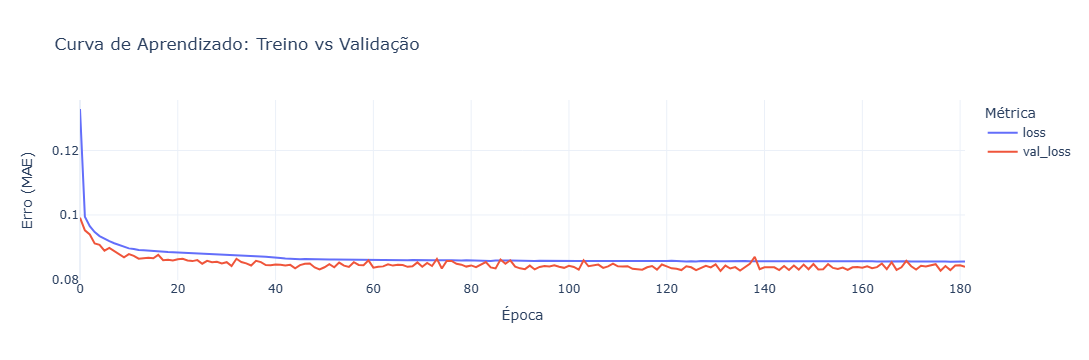

In [9]:
def save_static_plot(fig, filename):
    """Salva imagem estática sem título e exibe interativa."""
    filepath = os.path.join(OUTPUT_IMG_DIR, filename)
    
    # Remove título para salvar versão limpa
    layout_bkp = fig.layout.title.text
    fig.update_layout(title=None)
    fig.write_image(filepath, scale=2)
    
    # Restaura título e exibe
    fig.update_layout(title=layout_bkp)
    fig.show()

if 'history' in locals():
    hist_df = pd.DataFrame(history.history)
    hist_df['epoch'] = history.epoch
    
    fig_hist = px.line(
        hist_df, 
        x='epoch', 
        y=['loss', 'val_loss'], 
        labels={'value': 'Erro (MAE)', 'epoch': 'Época', 'variable': 'Métrica'},
        title='Curva de Aprendizado: Treino vs Validação',
        color_discrete_sequence=['#636EFA', '#EF553B']
    )
    fig_hist.update_layout(template='plotly_white')
    save_static_plot(fig_hist, "learning_curve.png")

In [10]:
if 'model' in locals():
    print("Avaliando modelo no conjunto de teste...")
    
    # Carregar melhor modelo salvo
    best_model = tf.keras.models.load_model(NN_CONFIG['model_save_path'], compile=False)
    best_model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    
    # Predição e Inversão da Escala
    y_pred_scaled = best_model.predict(X_test)
    y_pred_real = output_scaler.inverse_transform(y_pred_scaled)
    y_test_real = output_scaler.inverse_transform(y_test)
    
    # Montagem do DataFrame de Resultados
    results_df = test_df[['dev_eui', 'timestamp']].copy().reset_index(drop=True)
    results_df['gt_x'] = y_test_real[:, 0]
    results_df['gt_y'] = y_test_real[:, 1]
    results_df['pred_x'] = y_pred_real[:, 0]
    results_df['pred_y'] = y_pred_real[:, 1]
    
    # Cálculo do Erro Euclidiano (Metros)
    results_df['error_meters'] = np.sqrt(
        (results_df['gt_x'] - results_df['pred_x'])**2 + 
        (results_df['gt_y'] - results_df['pred_y'])**2
    )
    
    # Salvamento
    results_df.to_csv('nn_validation_results.csv', index=False)
    
    # Métricas Finais
    mae = results_df['error_meters'].mean()
    rmse = np.sqrt((results_df['error_meters']**2).mean())
    print(f"\n--- Resultados Finais (Teste) ---\nMAE: {mae:.2f} m\nRMSE: {rmse:.2f} m")
    
    # Visualização da Distribuição de Erro
    fig_dist = px.histogram(
        results_df, 
        x='error_meters', 
        nbins=50,
        title='Distribuição de Erro de Posicionamento (Conjunto de Teste)',
        labels={'error_meters': 'Erro (metros)'},
        opacity=0.7,
        color_discrete_sequence=['green']
    )
    fig_dist.add_vline(x=mae, line_dash="dash", annotation_text=f"Média: {mae:.1f}m")
    fig_dist.update_layout(template='plotly_white', bargap=0.1)
    
    save_static_plot(fig_dist, "error_distribution.png")

Avaliando modelo no conjunto de teste...
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

--- Resultados Finais (Teste) ---
MAE: 178.10 m
RMSE: 350.61 m
